In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform, split_time_series

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [7]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# 准备数据
df_complete = pd.read_csv ('../TockFormerData\SPY_2020-01-01_2025-05-03_60m.csv')

# 先把数据分成3份再create sequence，这样scale才不会泄漏
df_train, df_val, df_test = split_time_series(df_complete, 0.9, 0.05, 0.05)

In [9]:
target_cols = ['open', 'high', 'low', 'close']
seq_length = 32

# 创建序列
X_train, y_train, scaler, target_indices = create_sequences(df_train, seq_length=seq_length, target_cols=target_cols, scale=True)
X_val, y_val, _, _ = create_sequences(df_val, seq_length=seq_length, target_cols=target_cols, scaler=scaler)
X_test, y_test, _, _ = create_sequences(df_test, seq_length=seq_length, target_cols=target_cols, scaler=scaler)

数据被缩放
数据被缩放
数据被缩放


In [10]:
train_dataset = TensorDataset(X_train, y_train)
sample_dataset = sample_dataset(train_dataset, 0.1)  # 采样10%的数据用于超参数
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [11]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Sample dataset size: {len(sample_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 18119
Sample dataset size: 1811
Test dataset size: 1037
Val dataset size: 2103


In [ ]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset,
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

In [12]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

{'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 204. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 274. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 324. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 378. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 474. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 524. Reshuffling training data.
Epoch 1/50, Train Loss: 0.010727
Epoch 1/50, Val MSEs: [2604.896240234375, 2044.8226318359375, 3846.144287109375, 2755.934326171875], R²: [-4.236256122589111, -3.1647133827209473, -6.617798805236816, -4.5280561447143555]
Epoch 2: Bad batch threshold reached at batch 94. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 144. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 194. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 252. Reshuffl

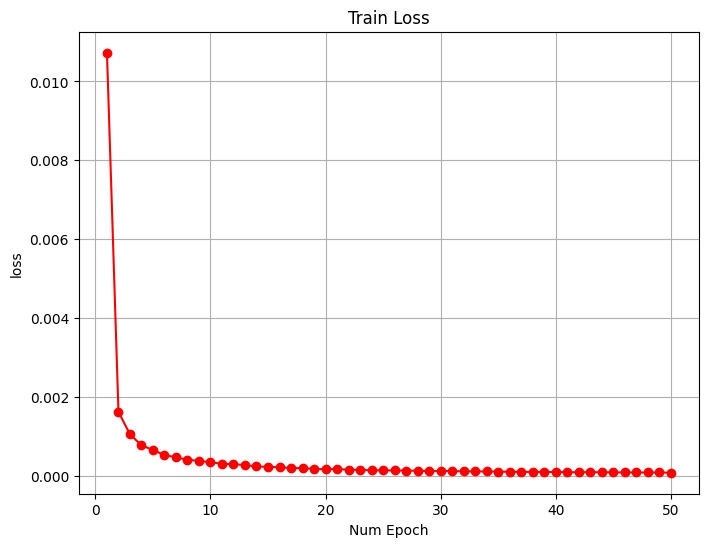

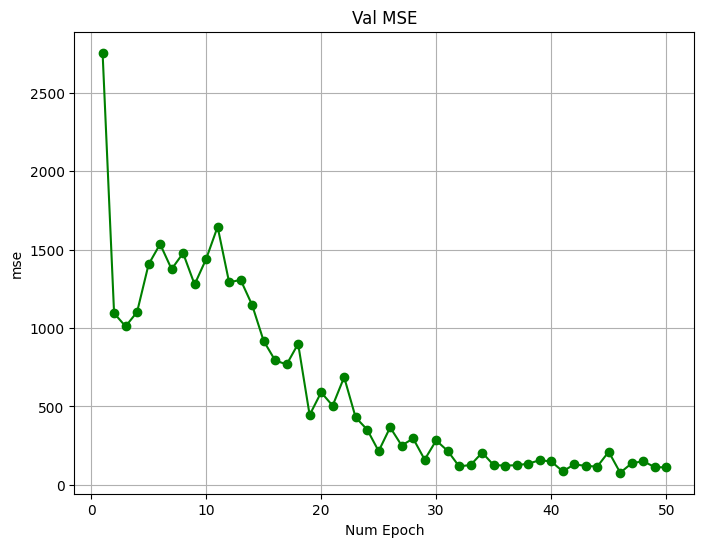

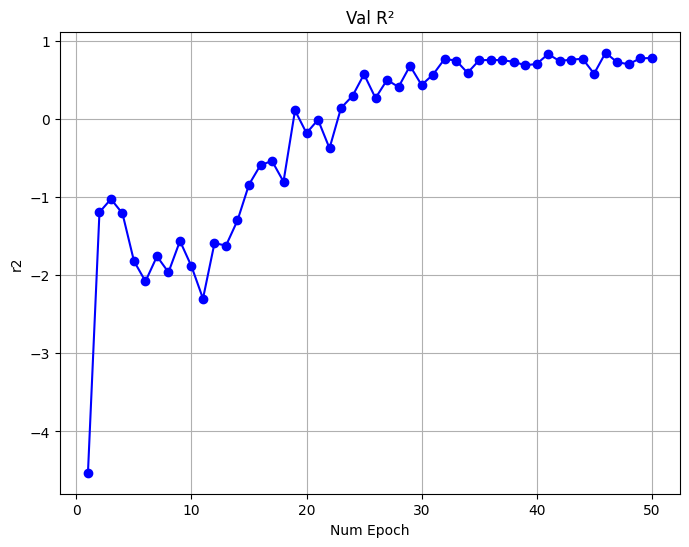

In [13]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [163.4443359375, 163.40704345703125, 161.13795471191406, 171.3617706298828]
测试集 R²:  [0.8197730779647827, 0.812389612197876, 0.8291897177696228, 0.8108464479446411]


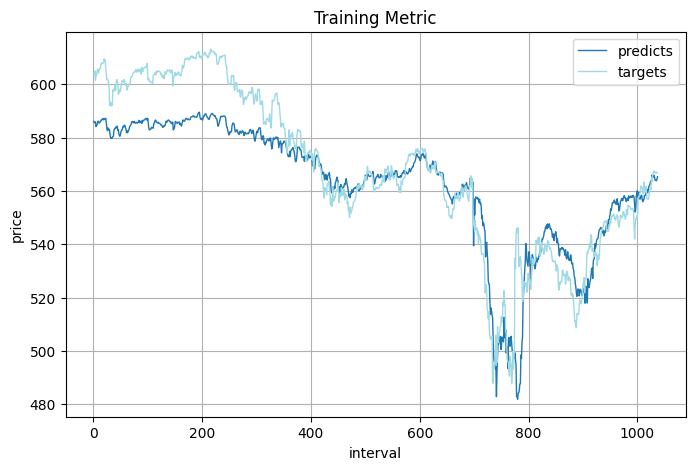

In [14]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset,
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

In [15]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1}

Using device: cuda
Epoch 1: reshuffling after 345 bad batches
Epoch 1: reshuffling after 487 bad batches
Epoch 1: reshuffling after 537 bad batches
Epoch 1/100, Loss: 0.026285
Epoch 1/100, Val MSEs: [1007.4120483398438, 1144.4371337890625, 1120.7022705078125, 1280.252685546875], R²: [-1.0250585079193115, -1.330888032913208, -1.2196996212005615, -1.5680253505706787]
Epoch 2: reshuffling after 103 bad batches
Epoch 2: reshuffling after 172 bad batches
Epoch 2: reshuffling after 222 bad batches
Epoch 2: reshuffling after 272 bad batches
Epoch 2: reshuffling after 332 bad batches
Epoch 2: reshuffling after 382 bad batches
Epoch 2: reshuffling after 432 bad batches
Epoch 2: reshuffling after 482 bad batches
Epoch 2: reshuffling after 553 bad batches
Epoch 2/100, Loss: 0.000273
Epoch 2/100, Val MSEs: [923.7868041992188, 968.035400390625, 1003.9469604492188, 951.09521484375], R²: [-0.8569583892822266, -0.9716087579727173, -0.9884500503540039, -0.907776951789856]
Epoch 3: reshuffling after 83 

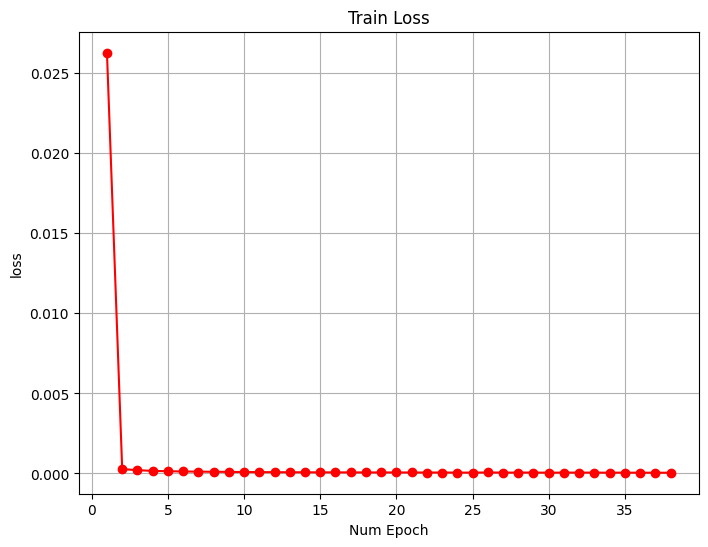

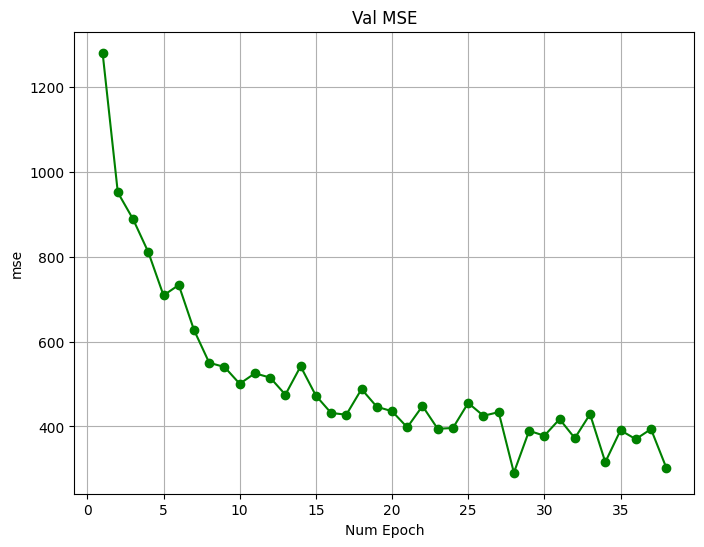

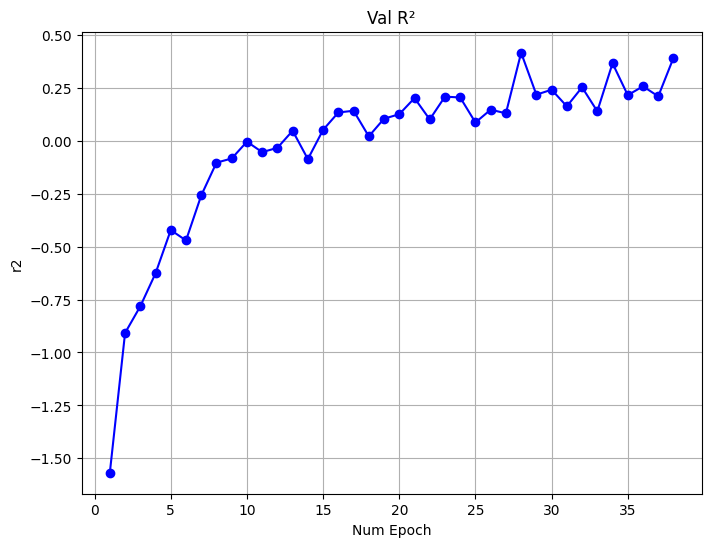

In [16]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [355.8622741699219, 353.49957275390625, 321.1334228515625, 347.96685791015625]
测试集 R²:  [0.6075974702835083, 0.5941411256790161, 0.659590482711792, 0.6159051656723022]


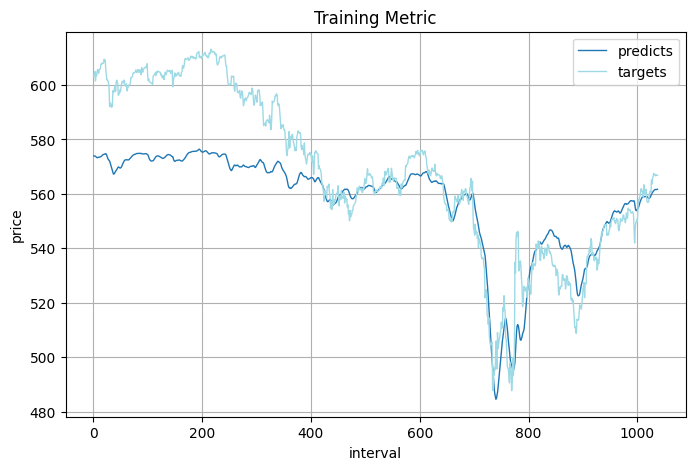

In [17]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [42]:
# 整理数据
X_val_tock = tock.predict_model (val_dataset, scaler=scaler, target_indices=target_indices)
X_val_lstm = lstm.predict_model (val_dataset, scaler=scaler, target_indices=target_indices)

X_val_bd = np.concatenate ((X_val_tock, X_val_lstm), axis=1)
y_val_bd = y_val

[autoreload of TransformerModel failed: Traceback (most recent call last):
  File "c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "c:\Users\hinye\miniconda3\envs\TockFormer\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "e:\ziwen\TockFormer\TransformerModel.py", line 295
    def predict_model (self, X_tensor, scaler, bi

TypeError: TimeSeriesTransformer.predict_model() got an unexpected keyword argument 'batch_size'

In [ ]:
# 训练blender


blender_params = {
    'base_models': [tock, lstm],  # 基础模型列表
    'output_dim': 4,  # 4个目标值
    'hidden_dims': [16],
    'dropout': 0.1,
}

blender = MLPBlender (**blender_params)

blender.fit (val_dataset,
             val_dataset=test_dataset,
            num_epochs=100,
            batch_size=32,
            lr=1e-4,
            patience=10,
            log=True)

Using device: cuda


Epoch 1: train_loss=1.058981, val_mse=0.943347, val_r2=[-126.00482940673828, -158.4640350341797, -47.12795639038086, -159.4202423095703]
Epoch 2: train_loss=0.918840, val_mse=0.803521, val_r2=[-105.20762634277344, -139.03109741210938, -38.875919342041016, -134.7183074951172]
Epoch 3: train_loss=0.771808, val_mse=0.666804, val_r2=[-85.00464630126953, -119.71803283691406, -30.49465560913086, -111.05774688720703]
Epoch 4: train_loss=0.639710, val_mse=0.537125, val_r2=[-66.20924377441406, -100.7640609741211, -22.530231475830078, -88.87383270263672]
Epoch 5: train_loss=0.513804, val_mse=0.418229, val_r2=[-49.362361907958984, -82.58463287353516, -15.549896240234375, -68.58946990966797]
Epoch 6: train_loss=0.395414, val_mse=0.314031, val_r2=[-35.032752990722656, -65.72409057617188, -9.789799690246582, -50.90391540527344]
Epoch 7: train_loss=0.300904, val_mse=0.227130, val_r2=[-23.56425666809082, -50.67743682861328, -5.47050666809082, -36.120792388916016]
Epoch 8: train_loss=0.217544, val_mse=

Blender weights:  {'model_TimeSeriesTransformer': 0.4685830771923065, 'model_TimeSeriesLSTM': 0.5314168930053711}
测试集 MSE:  [192.6306610107422, 190.53121948242188, 231.37672424316406, 178.0112762451172]
测试集 R²:  [0.7875898480415344, 0.7812478542327881, 0.7547348737716675, 0.8035064935684204]


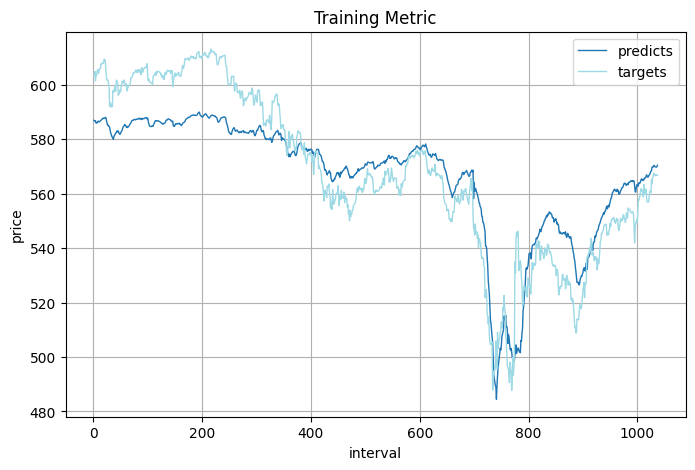

In [37]:
print ("Blender weights: ", blender.get_model_importance ())

mse_list_bd, r2_list_bd, preds_bd, targets = blender.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_bd)
print ("测试集 R²: ", r2_list_bd)

curve_dict = {}
curve_dict['predicts'] = preds_bd[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [38]:
preds_bd[:3]

array([[587.6146 , 586.2938 , 587.0636 , 586.9832 ],
       [587.42847, 586.1516 , 586.92267, 586.7741 ],
       [587.37744, 586.09375, 586.8671 , 586.72217]], dtype=float32)

In [39]:
preds_tock[:3]

array([[586.2345 , 587.38513, 586.6373 , 586.06824],
       [585.79724, 586.88025, 586.26105, 585.59766],
       [585.782  , 586.85254, 586.21106, 585.54443]], dtype=float32)

In [40]:
preds_lstm[:3]

array([[573.477  , 574.59094, 574.4107 , 573.95166],
       [573.4302 , 574.5514 , 574.36743, 573.91064],
       [573.3662 , 574.4935 , 574.3052 , 573.85223]], dtype=float32)

In [ ]:
# 训练 residual module

from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = tock.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = tock.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


In [ ]:
mse_list_cor, r2_list_cor, preds_cor, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)
# blender 估计也要保存

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)